In [1]:
from functions import initialize_snowslide_from_safran

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
dem_path = "/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/example/dem.tif"
ds_paths=["/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/comparaison_sentinel/Input/Données_SAFRAN/FORCING_2017080106_2018080106.nc",
          "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/comparaison_sentinel/Input/Données_SAFRAN/FORCING_2018080106_2019080106.nc"]
massif_id=3
frequency="M"
snow_density=150

prcpt = initialize_snowslide_from_safran(dem_path,ds_paths=ds_paths,massif_id=massif_id,frequency=frequency,snow_density=snow_density)

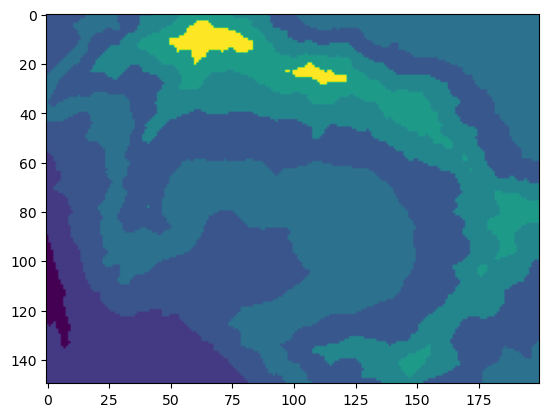

In [9]:
import matplotlib.pyplot as plt 
plt.imshow(prcpt[4])

In [6]:
# Routine pour télécharger directement les données sur la plateforme
# (1) - Ajouter une possibilité de download ou non : ici on développe la possibilité de download
import subprocess
import os

def download_aeris_data():
    os.system("wget -c -t 0 —timeout=60 —waitretry=300 -O 6a233c73-7290-4426-99a9-f6444694bb9e.zip https://api.sedoo.fr/aeris-s2m-rest/data/download/6a233c73-7290-4426-99a9-f6444694bb9e.zip")
        
    # filename = "4a5d92cb-c7b9-4177-bb0f-828f620769bc.zip"
    # # url = "https://api.sedoo.fr/aeris-s2m-rest/data/download/4a5d92cb-c7b9-4177-bb0f-828f620769bc.zip"
    # # url = "wget -c -t 0 —timeout=60 —waitretry=300 -O 6a233c73-7290-4426-99a9-f6444694bb9e.zip https://api.sedoo.fr/aeris-s2m-rest/data/download/6a233c73-7290-4426-99a9-f6444694bb9e.zip"
    # # url = "https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data5/adaptor.mars.internal-1702055963.8597312-24606-7-5fa91bf8-d2a2-452f-bc8a-eea0f7508db3.nc"

    # wget_command = ["wget","-c","-t", "0","--timeout=60","--waitretry=300",
    # "-O", "6a233c73-7290-4426-99a9-f6444694bb9e.zip",
    # "https://api.sedoo.fr/aeris-s2m-rest/data/download/6a233c73-7290-4426-99a9-f6444694bb9e.zip"
    # ]
    
    # try:
    #     subprocess.run(wget_command,check=True)
    # except Exception as e:
    #     print(f"Une erreur s'est produite : {e}")

In [7]:
# dst_path = "/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/snowslide/download_safran_data.nc"
download_aeris_data()

sh: wget: command not found


In [13]:
import subprocess

def runcmd(cmd, verbose = False, *args, **kwargs):

    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    pass

runcmd("wget -c -t 0 —timeout=60 —waitretry=300 -O 6a233c73-7290-4426-99a9-f6444694bb9e.zip https://api.sedoo.fr/aeris-s2m-rest/data/download/6a233c73-7290-4426-99a9-f6444694bb9e.zip",verbose = True)

 /bin/sh: wget: command not found



In [62]:
# Ecrire les routines pour télécharger puis post-processer les données ERA5
import cdsapi
import rasterio
import xarray as xr
import numpy as np
from pyproj import Proj, transform

def get_coordinates_central_point(dem_path) :
    """This function aims to compute the lon/lat coordinates of the center of a raster dem

    Parameters
    ----------
    dem_path: str
        Path to the dem

    Outputs
    -------
    lon,lat : tuple of floats
        Geographical coordinates in ° of the center of the dem
    """
    with rasterio.open(dem_path) as src:
        cols, rows = src.width // 2, src.height // 2
        crs = src.crs
        x, y = src.xy(rows, cols)
        in_proj = Proj(crs)
        out_proj = Proj(init='epsg:4326')
        lon, lat = transform(in_proj, out_proj, x, y)

    return lon,lat

def download_ERA5_data(start_date,end_date,dem_path,
                       variable=['2m_temperature','geopotential','total_precipitation'],
                       name = 'download_era5_data.nc'
                       ) :
    
    # List of years to select
    years = [str(i) for i in range(int(start_date[:4]),int(end_date[:4])+1)]
    # List of month to select
    month = ['01', '02', '03','04', '05', '06','07', '08', '09','10', '11', '12']
    if len(years) == 1:
        month = [str(i) for i in range(int(start_date[5:7]),int(end_date[5:7])+1)]
    # List of days
    day = ['01', '02', '03','04', '05', '06','07', '08', '09','10', '11', '12','13', '14', '15',
            '16', '17', '18','19', '20', '21','22', '23', '24','25', '26', '27','28', '29', '30','31']
    if len(month) == 1:
        day = [str(i) for i in range(int(start_date[8:10]),int(end_date[8:10])+1)]
    # Get the area from dem_path
    lon,lat = get_coordinates_central_point(dem_path)
    area = [round(lat+0.2,2),round(lon-0.2,2),round(lat-0.2,2),round(lon+0.2,2)]

    c = cdsapi.Client()

    try:
        c.retrieve(
            'reanalysis-era5-single-levels',
            {
                'product_type': 'reanalysis',
                'format': 'netcdf',
                'variable': variable,
                'year': years,
                'month': month,
                'day': day,
                'time': [
                    '00:00', '01:00', '02:00',
                    '03:00', '04:00', '05:00',
                    '06:00', '07:00', '08:00',
                    '09:00', '10:00', '11:00',
                    '12:00', '13:00', '14:00',
                    '15:00', '16:00', '17:00',
                    '18:00', '19:00', '20:00',
                    '21:00', '22:00', '23:00',
                ],
                'area': area,
            },
            name)
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")   

def initilialize_snowslide_from_era5(dem_path,ds_path,frequency="M",snow_d=200):
    """Function that creates SND0 matrices to initialize snowslide from ERA5 data
    
    Parameters
    ----------
    dem_path: Str
        Path to the dem file over which the user wants to initialize snow heights
    frequency: str
        Specifies the frequency over which snowslide is used.
        'D' : Day
        'W' : Week
        'M' : Month
        'Q' : quarter
        'A' : Year
    You can also specify a diferent frequency with for example '2M' that means '2 months'.
    snow_d: float
        Snow density. Default is 200 kg/m3

    Outputs
    -------
    time: list (np array)
        time coordinates of the output
    temperature: np array
        Snow heights initialization at each time step
"""
    # Importing dem
    dem = rasterio.open(dem_path).read(1)
    # Importing weather data and resampling to a chosen frequency
    ds = xr.open_dataset(ds_path)
    ds['time'] = xr.decode_cf(ds).time
    ds = ds.resample(time=frequency).mean(dim='time')

    # Choosing only variable for the nearest lon/lat point to the center of dem
    dem_lon,dem_lat = get_coordinates_central_point(dem_path)
    lon,lat = np.meshgrid(ds.longitude.values,ds.latitude.values)
    distance = np.sqrt((lon-dem_lon)**2 + (lat-dem_lat)**2)
    index = np.argmin(distance)
    lat_id,lon_id = np.unravel_index(index, distance.shape)
    ds = ds.isel(longitude=lon_id,latitude=lat_id)

    # Initializing the matrices
    temperature = []
    precipitation = []
    alt = float(ds.z.isel(time=0))/9.81 # Altitude computed from geopotential assuming g = 9.81 m.s-2
    grad = -6.5e-3 # Temperature gradient assuming it is -6.5 K.m-1
    time = ds.time.values

    # Creating init matrices at each time period
    i = 0
    for elt in time:
        t = float(ds.t2m.sel(time=elt).values) - 273.15 
        temp = (dem - alt)*grad + t
        temperature.append(temp)

        sf = ds.tp.sel(time=elt).values
        prcpt = np.zeros(np.shape(dem))
        prcpt[temperature[i] < 0] = sf
        # Going back to a snow height instead of water height using density
        prcpt = prcpt*(1000/snow_d) # Assuming water density is 1000 kg/m3
        precipitation.append(prcpt)

        i+=1

    return time, np.array(precipitation)

In [63]:
#from snowslide.preprocess_data import download_ERA5_data

# Let's download the data over specified period and localisation
start_date = '2020-01-01'
end_date = '2020-03-31'
dem_path = '/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/example/dem.tif'
download_ERA5_data(start_date,end_date,dem_path)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/5j/5cpnb1rn2ljgh2mqrjz6kpk00000gn/T/ipykernel_49121/2101611302.py:27: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(in_proj, out_proj, x, y)
2023-12-12 17:58:07,586 INFO Welcome to the CDS
2023-12-12 17:58:07,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-12-12 17:58:07,660 INFO Request is queued
2023-12-12 17:58:10,301 INFO Request is running
2023-12-12 18:06:27,158 INFO Request is comp

In [67]:
dem_path = "/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/example/dem.tif"
ds_path = "/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/example/tutorials/download_era5_data.nc"
time, precipitations = initilialize_snowslide_from_era5(dem_path,ds_path,frequency="M",snow_d=200)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/5j/5cpnb1rn2ljgh2mqrjz6kpk00000gn/T/ipykernel_49121/2101611302.py:27: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(in_proj, out_proj, x, y)


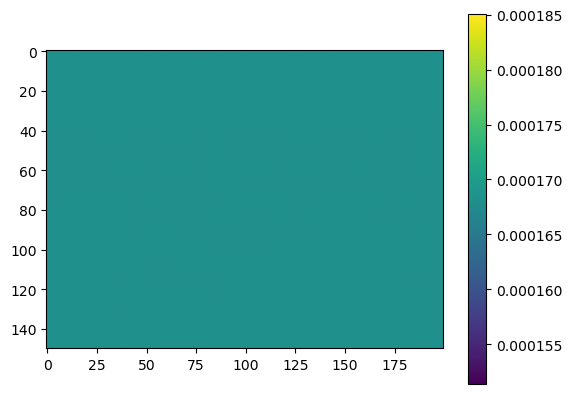

In [71]:
plt.imshow(precipitations[0])
plt.colorbar()

In [25]:
ds_path = "/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/snowslide/download_era5_data.nc"
dem_path = "/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/example/dem.tif"
snow_d = 200

dem = rasterio.open(dem_path).read(1)
# Importing weather data and resampling to a chosen frequency
ds = xr.open_dataset(ds_path)
ds['time'] = xr.decode_cf(ds).time
ds = ds.resample(time='1M').mean(dim='time')

# Choosing only variable for the nearest lon/lat point to the center of dem
dem_lon,dem_lat = get_coordinates_central_point(dem_path)
lon,lat = np.meshgrid(ds.longitude.values,ds.latitude.values)
distance = np.sqrt((lon-dem_lon)**2 + (lat-dem_lat)**2)
index = np.argmin(distance)
lat_id,lon_id = np.unravel_index(index, distance.shape)
ds = ds.isel(longitude=lon_id,latitude=lat_id)
ds

# Initializing the matrices
temperature = []
precipitation = []
alt = float(ds.z.isel(time=0))/9.81 # Altitude computed from geopotential assuming g = 9.81 m.s-2
grad = -6.5e-3 # Temperature gradient assuming it is -6.5 K.m-1
time = ds.time.values

i = 0
for elt in time:
    t = float(ds.t2m.sel(time=elt).values) - 273.15 
    temp = (dem - alt)*grad + t
    temperature.append(temp)

    sf = ds.tp.sel(time=elt).values
    prcpt = np.zeros(np.shape(dem))
    prcpt[temperature[i] < 0] = sf
    # Going back to a snow height instead of water height using density
    prcpt = prcpt*(1000/snow_d) # Assuming water density is 1000 kg/m3
    precipitation.append(prcpt)

    i+=1

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/5j/5cpnb1rn2ljgh2mqrjz6kpk00000gn/T/ipykernel_49121/4001547662.py:22: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(in_proj, out_proj, x, y)


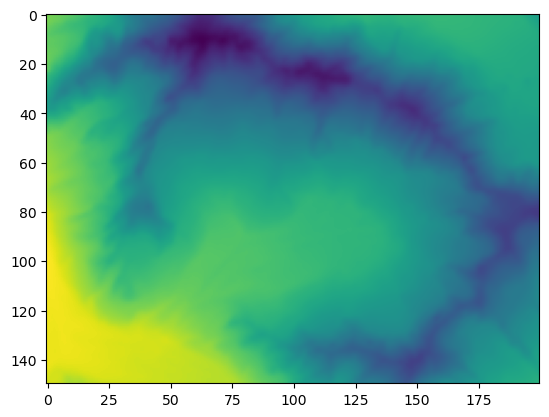

In [30]:
import matplotlib.pyplot as plt
plt.imshow(temperature[1])